# TD2 : image classification

S. Delprat, INSA Hauts-de-France  
  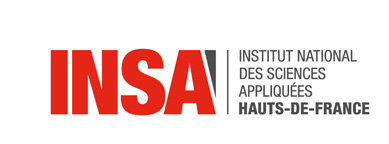


This is a guided exercice to understand how to build an efficient classification network. The dataset has been kept small enough such that the training time remain small.

In [1]:
# Necessary on collab
# %pip install torchinfo

In [2]:
# Standard library imports
import os
import math
import shutil
import zipfile
import time
import random

# MUST BE RUN BEFORE 'import torch' (for reproducibility, see below)
# We must ensure CUBLAS is also deterministic, or it will throw an error.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Data related
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from torchinfo import summary

# Reproducibility
SEED = 0
random.seed(SEED)                           # For Python
np.random.seed(SEED)                        # For Numpy, or modules that uses numpy
torch.manual_seed(SEED)                     # For PyTorch
torch.cuda.manual_seed_all(SEED)            # Sets the seed for CPU and GPU
torch.backends.cudnn.benchmark = False      # Enforces CUDA to always use the same algorithms. May decrease performances.
torch.backends.cudnn.deterministic = True   # Enforces the given algorithms to be deterministic.

/home/que762/Documents/DeepLearning-PytorchEnv/pytorch-env-DeepLearning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check cuda version

In [3]:
torch.__version__

'2.5.1+cu124'

Configuration of the hyperparameters

In [4]:
experimentName      = "step5"
datasetFolder       = '../data/processed/datasetFlower'
outputFolder        = os.path.join("../models/td2/result", experimentName)
batchSize           = 128       # Keep it low for faster iterations (for low-end gpus)
n_channels          = 3         # Colored images
H, W                = 64, 64    # image height & width
learningRate        = 0.001     # Size of the step to make to optimize weights at each iteration.
validateEveryIter   = 10        # How many iters before validation
numEpoch            = 300       # Number of epoch for the training
weight_decay        = 0.5       # Regularize weights to prevent exploding gradient and overfitting.

Empty & create output folder

In [5]:
if os.path.isdir(outputFolder):
    shutil.rmtree(outputFolder)
os.makedirs(outputFolder)

**Q1.** Check for GPU
Create a variable `device` that is equal to `cuda` or `cpu` depending on the availability of a GPU

In [6]:
# Check for GPU.
for gpu_idx in range(torch.cuda.device_count()):
    print(f"GPU {gpu_idx}: {torch.cuda.get_device_name(gpu_idx)}")

# Create a variable 'device' that is equal to 'cuda' if a GPU is available, and 'cpu' if no GPU is available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
Using device:  cuda:0


# 1) Working with the studied dataset

## 1.2) Load some data

**Q2.** Import data
1. Copy the "flower" zip file into your Google Drive.
2. Share it using link
3. Use the file ID to copy this file into this Colab virtual machine (using gdown).


We run locally here, so we just put it at the correct path.

In [7]:
# Check if the flower.zip file is in the current directory
# If not, download it from the given URL
# If yes, print "File already exists"
archiveName = "../data/raw/flower.zip"
if not os.path.isfile(archiveName):
    print("Download the file and place it in the current directory")
else:
    print(f"File {archiveName} already in the current directory")

File ../data/raw/flower.zip already in the current directory


Extract the archive into the `datasetFolder`

In [8]:
if not os.path.isdir(datasetFolder):
    # uncompress the archive
    print(datasetFolder)
    with zipfile.ZipFile(os.path.join(os.getcwd(), archiveName), 'r') as zip_ref:
        zip_ref.extractall(datasetFolder)
        print("Dataset is extracted")
else:
    print("Dataset is already extracted")

Dataset is already extracted


## 1.2) Dataset & dataloader



The following object allows loading the entire dataset into memory. As a result, there is no need to load images on the fly, and the CPU computation requirement is less.
However, the machine needs to have enough memory to store all the data.

In [9]:
class inMemoryImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, imSize=None, NbClass=None, maxFilesPerClass=None):
        self.root = os.path.expanduser(root)
        self.imSize = imSize
        self.classes = sorted(entry.name for entry in os.scandir(self.root) if entry.is_dir())

        if not self.classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {self.root}.")

        if NbClass is not None:
            # Limit the number of class
            self.classes = self.classes[:NbClass]

        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Scan each class folder
        self.allFilename = []
        self.allIdx = []

        for i, className in enumerate(self.classes):
            idx = self.class_to_idx[className]
            target_dir = os.path.join(self.root, className)
            classFileNameList = []
            classIdxList = []
            # sort all the subfolders
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for file in fnames:
                    if maxFilesPerClass is None or len(classFileNameList) < maxFilesPerClass:
                        file_path = os.path.join(root, file)
                        classFileNameList.append(file_path)
                        classIdxList.append(idx)
            self.allFilename = self.allFilename + classFileNameList
            self.allIdx = self.allIdx + classIdxList

        # read images
        self.allImgs = []
        progressBar = tqdm(
            self.allFilename,
            desc="Loading dataset in memory",
            total=len(self.allFilename))

        for file in progressBar:
            with open(file, "rb") as f:
                img = Image.open(f)
                if self.imSize is not None:
                    self.allImgs.append(img.resize(self.imSize).convert("RGB"))
                else:
                    self.allImgs.append(img.convert("RGB"))

    def __len__(self):
        return len(self.allFilename)

    def __getitem__(self, idx):
        return self.allImgs[idx], self.allIdx[idx]

**Q3.** Dataset creation
* Create a dataset `all_train_data` for the training data, with no transformations.
* Split this dataset into `train_data` (70%) and `validation_data` (30%).
* Create a dataset `test_data` with the test images
* Create a variable `nClass` containing the number of classes from the dataset.
* Store the available classes in `classes`
* Store the available classes in `classes`

NB: you may/should use the `inMemoryImageFolder` instead of the original `ImageFolder` dataset provided by PyTorch.



In [10]:
# * Create a dataset `all_train_data` for the training data, with no transformations. Train data are located in the `train` folder.
# * Split this dataset into `train_data` (70%) and `validation_data` (30%).
# * Create a dataset `test_data` with the test images. Test data are located in the `test` folder.
# * Create a variable `nClass` containing the number of classes from the dataset.
# * Store the available classes in `classes`
# * Store the available classes in `classes`

# NB: you may/should use the `inMemoryImageFolder` instead of the original `ImageFolder` dataset provided by PyTorch.

print("Previous version that doesn't stratify using the classes")
# all_train_data              = inMemoryImageFolder(os.path.join(datasetFolder, "train"), imSize=(H, W))
# train_data, validation_data = torch.utils.data.random_split(all_train_data, [0.7, 0.3])
# test_data                   = inMemoryImageFolder(os.path.join(datasetFolder, "test"), imSize=(H, W))
# nClass                      = len(all_train_data.classes)
# classes                     = all_train_data.classes

Previous version that doesn't stratify using the classes


We want to stratify so that the class distribution is similar between the train, test and validation.

In [11]:
# 1) Load the entire dataset
all_train_data = inMemoryImageFolder(
    os.path.join(datasetFolder, "train"),
    imSize=(H, W)
)

# 2) Prepare for stratified splitting:
#    -> We'll need an index list [0, 1, 2, ...] and a labels list for stratification
all_indices = list(range(len(all_train_data)))
all_labels = [all_train_data.allIdx[i] for i in all_indices]  # numeric labels of every sample

# 3) We perform the stratified split (70% train / 30% validation here)
train_idx, val_idx = train_test_split(
    all_indices,
    test_size=0.3,
    stratify=all_labels, # Equal class distribution
    random_state=SEED    # Reproducibility
)

# 4) We create `Subset` objects for PyTorch
train_data = Subset(all_train_data, train_idx)
validation_data = Subset(all_train_data, val_idx)

# 5) Load separate test data folder (no split needed)
test_data = inMemoryImageFolder(
    os.path.join(datasetFolder, "test"),
    imSize=(H, W)
)

# 6) Access classes and define variables
nClass = len(all_train_data.classes)
classes = all_train_data.classes

print(f"Training samples: {len(train_data)} | Validation samples: {len(validation_data)} | Test samples: {len(test_data)}")

Loading dataset in memory: 100%|██████████| 272/272 [00:00<00:00, 1020.57it/s]

Training samples: 1731 | Validation samples: 743 | Test samples: 272


In [12]:
print(f"Number of classes: {nClass}\nClasses: ", end="")
for data_class in classes[:-1]:
    print(data_class, end=", ")
print(classes[-1])

Number of classes: 5
Classes: daisy, dandelion, rose, sunflower, tulip


We verify that the class distribution is similar

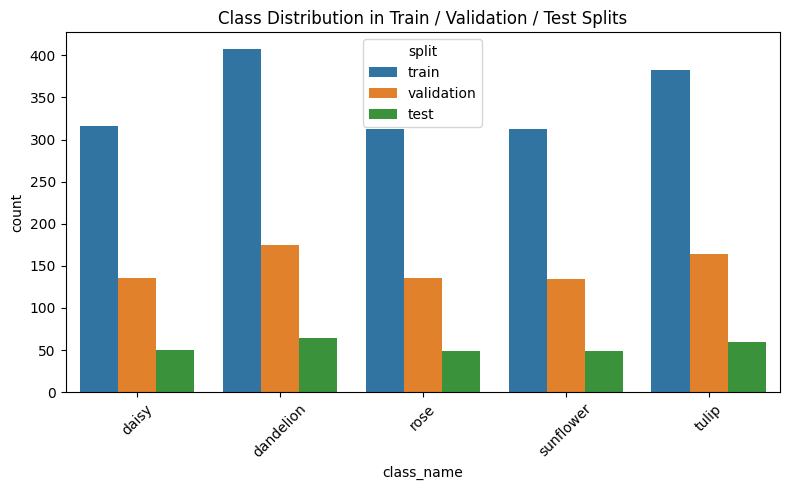

In [13]:
# 1) Gather labels from splits
# Extract numeric labels (indices) from train_data
train_labels = [all_train_data.allIdx[i] for i in train_data.indices]

# Extract numeric labels from validation_data
val_labels = [all_train_data.allIdx[i] for i in validation_data.indices]

# Optionally, if you want to include test_data as well:
test_labels = [test_data.allIdx[i] for i in range(len(test_data))]

# 2) Count how many samples per class
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts   = pd.Series(val_labels).value_counts().sort_index()
test_counts  = pd.Series(test_labels).value_counts().sort_index()

# 3) Build a single DataFrame combining all splits
df_train = pd.DataFrame({
    'class_idx': train_counts.index,
    'count': train_counts.values,
    'split': 'train'
})
df_val = pd.DataFrame({
    'class_idx': val_counts.index,
    'count': val_counts.values,
    'split': 'validation'
})
df_test = pd.DataFrame({
    'class_idx': test_counts.index,
    'count': test_counts.values,
    'split': 'test'
})

df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Convert the numeric class_idx to class names (optional, but more readable)
df['class_name'] = df['class_idx'].apply(lambda idx: all_train_data.classes[idx])

# 4) Plot with seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='class_name', y='count', hue='split')
plt.title("Class Distribution in Train / Validation / Test Splits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Q4.** Create required transformations:
* `formatTransform`  : comprising `Resize`, `PILToTensor`, `ToDtype`
* `augmentTransform` : `RandomRsizedCrop`, `RandomHorizontalFlip`, `PILToTensor`, `ToDtype`

Nb: the images should be `float32` tensor. Use `v2.ToDtype(torch.float32, scale=True)`

In [14]:
# Create required transformations:
# * `formatTransform`  : comprising `Resize`, `PILToTensor`, `ToDtype`
# * `augmentTransform` : `RandomResizedCrop`, `RandomHorizontalFlip`, `PILToTensor`, `ToDtype`

# Nb: the images should be `float32` tensor. Use `v2.ToDtype(torch.float32, scale=True)`

formatTransform = v2.Compose([
    v2.Resize((H, W)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

augmentTransform = v2.Compose([
    v2.RandomResizedCrop((H, W)),
    v2.RandomHorizontalFlip(),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

The `transformedDataset` object, derived from `the torch.utils.data.Dataset` class, applies a given transformation to an existing dataset.

In [15]:
class transformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return self.transforms(image), label  # Get the image, not the sample

**Q5.** Create 3 `transformedDataset` objects (`train_data`, `validation_data`,`test_data`), one for each subset (train, validation and test) using the `formatTransform` transformation defined in question Q5 (`augmentTransform` will only be used later)

In [16]:
# **Q5.** Create 3 `transformedDataset` objects (`train_data`, `validation_data`,`test_data`), one for each subset
# (train, validation and test) using the `formatTransform` transformation defined in question Q5
# (`augmentTransform` will only be used later)

# Previous step
# train_data = transformedDataset(train_data, formatTransform)
# validation_data = transformedDataset(validation_data, formatTransform)
# test_data = transformedDataset(test_data, formatTransform)

# We now augment the date
train_data      = transformedDataset(train_data, augmentTransform)
validation_data = transformedDataset(validation_data, formatTransform)
test_data       = transformedDataset(test_data, formatTransform)

**Q7.** define a dataloader for all the datasets

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# Define a dataloader for all the datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, generator=g, worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batchSize, shuffle=True, generator=g, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=False)

Use the dataloader to retrieve one batch and display some images

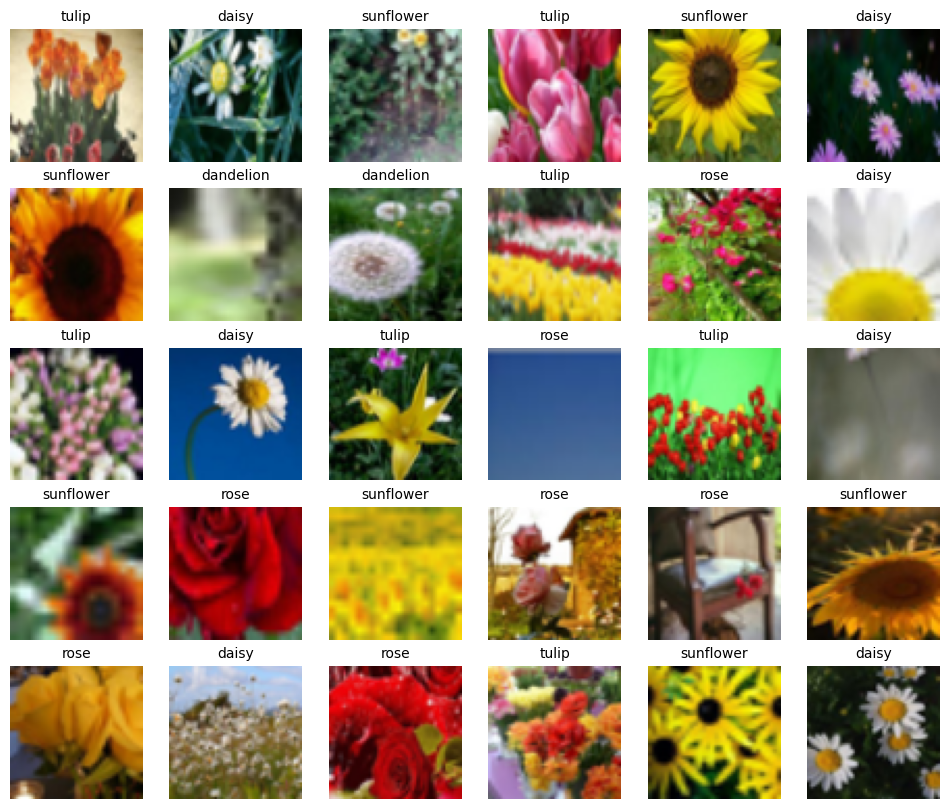

In [18]:
imgsBatch, lblBatch = next(iter(train_loader))
nImgs = 30
cols = int(math.ceil(math.sqrt(nImgs)))  # Number of columns (square root rounded up)
rows = int(math.ceil(nImgs / cols))  # Number of rows (ensure enough rows to fit images)

# Create the figure with the calculated number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Adjust figsize to the grid
axes = axes.ravel()

for i in range(nImgs):
    ax = axes[i]
    ax.imshow(imgsBatch[i, :].permute(1, 2, 0))
    ax.set_title(classes[lblBatch[i]], fontsize=10)
    ax.axis('off')

# 2) Define a model

Here is where the magic happens.

**Q6.** Define the `myConvNet` model class as described in the subject. The model takes a batch of images at input and provides a batch of logits as an output.

In [19]:
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()

        # 1) First conv (3 -> 8), ReLU, then AvgPool 2×2 : input shape [batch_size, 3, 64, 64]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=8, eps=1e-5, momentum=0.1, affine=True)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 2) Second conv (8 -> 16), ReLU, then AvgPool 2×2 : input shape [batch_size, 8, 32, 32]
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=16, eps=1e-5, momentum=0.1, affine=True)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 3) Third conv (16 -> 32), ReLU, then AvgPool 2×2 : input shape [batch_size, 16, 16, 16]
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=32, eps=1e-5, momentum=0.1, affine=True)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # -- No more pooling from here, which means image patches dimensions remain the same, only the number of filters increases --
        # 4) 4th conv (32 -> 64), ReLU : input shape [batch_size, 32, 8, 8]
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(num_features=64, eps=1e-5, momentum=0.1, affine=True)

        # 5) 5th conv (64 -> 128), ReLU : input shape [batch_size, 64, 8, 8]
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=128, eps=1e-5, momentum=0.1, affine=True)

        # 6) Final fully connected layer (128 -> nClass) : input shape [batch_size, 128, 8, 8] flattened to [batch_size, 128 * 8 * 8]
        self.fc = nn.Linear(128 * 8 * 8, nClass)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # block 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # block 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # block 4
        x = F.relu(self.conv4(x))
        # block 5
        x = F.relu(self.conv5(x))
        # flatten
        x = x.view(x.size(0), -1)
        return self.fc(x)

**Q7.** Create an instance of your model object `model` and send it to the GPU if available (use the "device" variable defined in Q1)

In [20]:
model = myConvNet().to(device)

**Q8.** Display model using `summary` from the `torchsummary` module.

In [21]:
# Display model using summary from the torchsummary module
summary(model, input_size=(batchSize, n_channels, H, W))

Layer (type:depth-idx)                   Output Shape              Param #
myConvNet                                [128, 5]                  480
├─Conv2d: 1-1                            [128, 8, 64, 64]          224
├─AvgPool2d: 1-2                         [128, 8, 32, 32]          --
├─Conv2d: 1-3                            [128, 16, 32, 32]         1,168
├─AvgPool2d: 1-4                         [128, 16, 16, 16]         --
├─Conv2d: 1-5                            [128, 32, 16, 16]         4,640
├─AvgPool2d: 1-6                         [128, 32, 8, 8]           --
├─Conv2d: 1-7                            [128, 64, 8, 8]           18,496
├─Conv2d: 1-8                            [128, 128, 8, 8]          73,856
├─Linear: 1-9                            [128, 5]                  40,965
Total params: 139,829
Trainable params: 139,829
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.18
Input size (MB): 6.29
Forward/backward pass size (MB): 71.31
Params size (MB): 0.56
Estimated

# 3) Train network

## 3.1) define optimizer

**Q9.** Define an Adam optimizer for the model parameters with:
* `learningRate`: learning rate
* `weight_decay`: L2 weigh parameter



In [22]:
# Define an Adam optimizer for the model parameters with:
# * learning rate `learningRate`
# * L2 weight parameter `weight_decay`
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weight_decay)

**Q10.** Define criterion object (`torch.nn.CrossEntropyLoss`) with `sum` as a reduction scheme. Do not forget to send this object to the computing device


Be aware that the CrossEntropyLoss function inputs is logits
* you must NOT include the `softmax` function in the network
* `softmax` function is integrated within the `CrossEntropyLoss` function

You must send the function to the selected device (CPU or GPU) according to the `device` variable

In [23]:
# Define criterion object (`torch.nn.CrossEntropyLoss`) with `sum` as a reduction scheme. Do not forget to send this object to the computing device


# Be aware that the CrossEntropyLoss function inputs is logits
# * you must NOT include the `softmax` function in the network
# * `softmax` function is integrated within the `CrossEntropyLoss` function

# You must send the function to the selected device (CPU or GPU) according to the `device` variable
criterion = torch.nn.CrossEntropyLoss(reduction='sum').to(device)

## 3.2) Setup tensorboard for visualization

Tensorboard should only be setup once the main program is working. For this exercise, priority is set on writing a working code, visualization comes after

**Q11.** Load the Tensorboard extension and eventually empty the log folder (using a command such as !rm -rf ./logs/)

In [24]:
#TensorBoard: cleanup to be used if you are using windows
tensorBoardFolder = "../models/td2/logs"
if os.path.isdir(tensorBoardFolder):
    shutil.rmtree(tensorBoardFolder)

In [25]:
#Load the TensorBoard notebook extension
%load_ext tensorboard

**Q12.** Create 2 `torch.utils.tensorboard.SummaryWriter` object called `writerTrain` and `writerVal` pointing to `./logs/train` and `./logs/val`

In [26]:
writerTrain = SummaryWriter(os.path.join(tensorBoardFolder, "train"))
writerVal = SummaryWriter(os.path.join(tensorBoardFolder, "val"))

The following line load the tensorboard extension

In [27]:
%tensorboard --logdir "../models/td2/logs"

**Q13.** load a batch of data from `train_loader`. Send the images to the device and use the `writerTrain.add_graph` method to allow the model visualization from tensorboard

In [28]:
# Load a batch of data from `train_loader`. Send the images to the device and use the `writerTrain.add_graph` method to 
# allow the model visualization from tensorboard

imgsBatch, lblBatch = next(iter(train_loader))
imgsBatch = imgsBatch.to(device)
writerTrain.add_graph(model, imgsBatch)

## 3.3) Main training loop

**Q14.** Create a python dictionary `history` with the following keys : `train_loss`,`train_acc`,`train_x`,`val_loss`,`val_acc`,`val_x`. Each of these keys are associated with an empty list.

In [29]:
history = {
    "train_loss": [],   # Training Loss
    "train_acc": [],    # Training accuracy
    "train_x": [],      # We accumulate the number of iterations of training data for plotting
    "val_loss": [],     # Validations Loss
    "val_acc": [],      # Validation accuracy
    "val_x": []         # We accumulate the number of iterations of training data for plotting
}

## 3.3) Illustration of the tqdm progress bar (to be used in the main loop)

tqdm allows displaying a progress bar. It can be used within a loop to enumerate an iterable (a simple list in this case, but it can be a dataloader object as well). You need to provide (beside the iterable object) the number of iterations in the "total" parameter, a description in the "desc" parameter.

At every iteration, you may write some values at the end of the line by providing a dicrtionary to the "set_postfix" method


In [30]:
progress_bar_ex = tqdm(
    enumerate([10, 20, 30, 40]),
    desc="Begining of the line ",
    total=4)

j_iter = 0
for i_iter in progress_bar_ex:
    j_iter = j_iter + j_iter
    time.sleep(0.3)
    progress_bar_ex.set_postfix(
        {
            "curr j val": j_iter,
            "curr i val": i_iter
        })

Begining of the line : 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, curr j val=0, curr i val=(3, 40)]


**Q15.** Write the main loop code

Read carefully all the instructions provided in the subject.


In [31]:
def train(num_epochs=numEpoch):
    """
    Train the model for `num_epochs` epochs,
    validating every `validateEveryIter` iterations,
    but keep only a single progress bar across epochs.
    """
    print(f"Training using {device}")
    start = time.time()
    iteration = 0

    # For tracking last validation predictions and labels
    val_loss, val_acc = None, None

    # Calculate total training steps (epochs * number_of_batches)
    total_steps = num_epochs * len(train_loader)

    # Create a single progress bar for all epochs
    progress_bar = tqdm(total=total_steps, desc="Training", leave=True)

    for epoch in range(num_epochs):
        model.train()

        for imgsBatch, yTrue in train_loader:
            iteration += 1

            # Forward & Backward passes
            imgsBatch, yTrue = imgsBatch.to(device), yTrue.to(device)   # Send to device
            optimizer.zero_grad()                                       # Reset Gradients every iter
            yPred = model(imgsBatch)                                    # Infer
            loss = criterion(yPred, yTrue)                              # Compute loss
            loss.backward()                                             # Compute gradients and back-propagate it
            optimizer.step()                                            # Take a step in the best direction

            # Normalize loss and accuracy by batch size
            batch_size = imgsBatch.size(0)
            train_loss = loss.item() / batch_size
            train_acc = (yPred.argmax(dim=1) == yTrue).sum().item() / batch_size

            # Store training metrics in history
            history["train_x"].append(iteration)
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)

            # Write to TensorBoard
            writerTrain.add_scalar("Loss", train_loss, iteration)
            writerTrain.add_scalar("Accuracy", train_acc, iteration)

            # Update the progress bar
            progress_bar.update(1)  # Advance by one batch
            progress_bar.set_description_str(f"Epoch {epoch + 1}/{num_epochs}")
            progress_bar.set_postfix({
                "Training Loss": f"{train_loss:.3f}",
                "Training Accuracy": f"{train_acc:.3f}",
                "Validation Loss": f"{val_loss:.3f}" if val_loss is not None else None,
                "Validation Accuracy": f"{val_acc:.3f}" if val_acc is not None else None,
            })

            # Validate every validateEveryIter (such as every 10 iterations)
            if iteration % validateEveryIter == 0:
                val_loss, val_acc = validate_once(
                    model, val_loader, criterion, history, writerVal, iteration, device
                )

    # Close the progress bar after all epochs
    progress_bar.close()

    # Compute the elapsed time
    train_duration = time.time() - start
    print(f"Training duration: {train_duration:.2f}s")
    return train_duration


def validate_once(model, val_loader, criterion, history, writerVal, iteration, device):
    """
    Run validation on the entire validation set.
    Returns validation loss, accuracy, predictions, and labels.
    """
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_x = 0

    yPreds, yTrues = [], []
    with torch.no_grad():
        for imgsBatch, yTrue in val_loader:
            imgsBatch, yTrue = imgsBatch.to(device), yTrue.to(device)

            # Forward pass
            yPred = model(imgsBatch)
            loss = criterion(yPred, yTrue)

            batch_size = imgsBatch.size(0)
            val_loss += loss.item()
            val_acc += (yPred.argmax(dim=1) == yTrue).sum().item()
            val_x += batch_size

            yPreds.append(yPred.argmax(dim=1).cpu().numpy())
            yTrues.append(yTrue.cpu().numpy())

    val_loss /= val_x
    val_acc /= val_x

    # Concatenate all predictions and ground truths
    yPreds = np.concatenate(yPreds)
    yTrues = np.concatenate(yTrues)

    # Record validation metrics
    history["val_x"].append(iteration)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Write to TensorBoard
    writerVal.add_scalar("Loss", val_loss, iteration)
    writerVal.add_scalar("Accuracy", val_acc, iteration)

    # Compute Confusion Matrix using the last validation predictions
    cm = confusion_matrix(yTrues, yPreds)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)

    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d")
    writerVal.add_figure("Confusion Matrix", plt.gcf(), iteration)

    return val_loss, val_acc

In [32]:
trainingDuration = train(num_epochs=numEpoch)

Training using cuda:0


Epoch 300/300: 100%|██████████| 4200/4200 [04:09<00:00, 16.82it/s, Training Loss=0.666, Training Accuracy=0.806, Validation Loss=0.858, Validation Accuracy=0.676]

Training duration: 249.78s


## 3.4) Save model and training curve data

In [33]:
torch.save(model, os.path.join(outputFolder, "model.zip"))

In [34]:
# Create separate DataFrames for train and validation using iteration as the key
df_train = pd.DataFrame({
    "Iteration": history['train_x'],
    "Training Loss": history['train_loss'],
    "Training Accuracy": history['train_acc']
})

df_val = pd.DataFrame({
    "Iteration": history['val_x'],
    "Validation Loss": history['val_loss'],
    "Validation Accuracy": history['val_acc']
})

# Merge on iteration
df_combined = pd.merge(df_train, df_val, on="Iteration", how="outer")
df_combined.to_csv(os.path.join(outputFolder, "metrics_data.csv"), sep=';', index=False)

In [35]:
print(f"Shape the combined dataframe: {df_combined.shape}")
df_combined.head(100)

Shape the combined dataframe: (4200, 5)


,Iteration,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,1,1.609497,0.179688,NaN,NaN
1,2,1.621010,0.265625,NaN,NaN
2,3,1.616050,0.195312,NaN,NaN
3,4,1.597210,0.265625,NaN,NaN
4,5,1.595594,0.304688,NaN,NaN
...,...,...,...,...,...
95,96,1.355238,0.390625,NaN,NaN
96,97,1.311765,0.445312,NaN,NaN
97,98,1.377585,0.343284,NaN,NaN
98,99,1.484743,0.351562,NaN,NaN


# 4) Analyze obtained results

## 4.1) Training curves

Display training curves using data from history

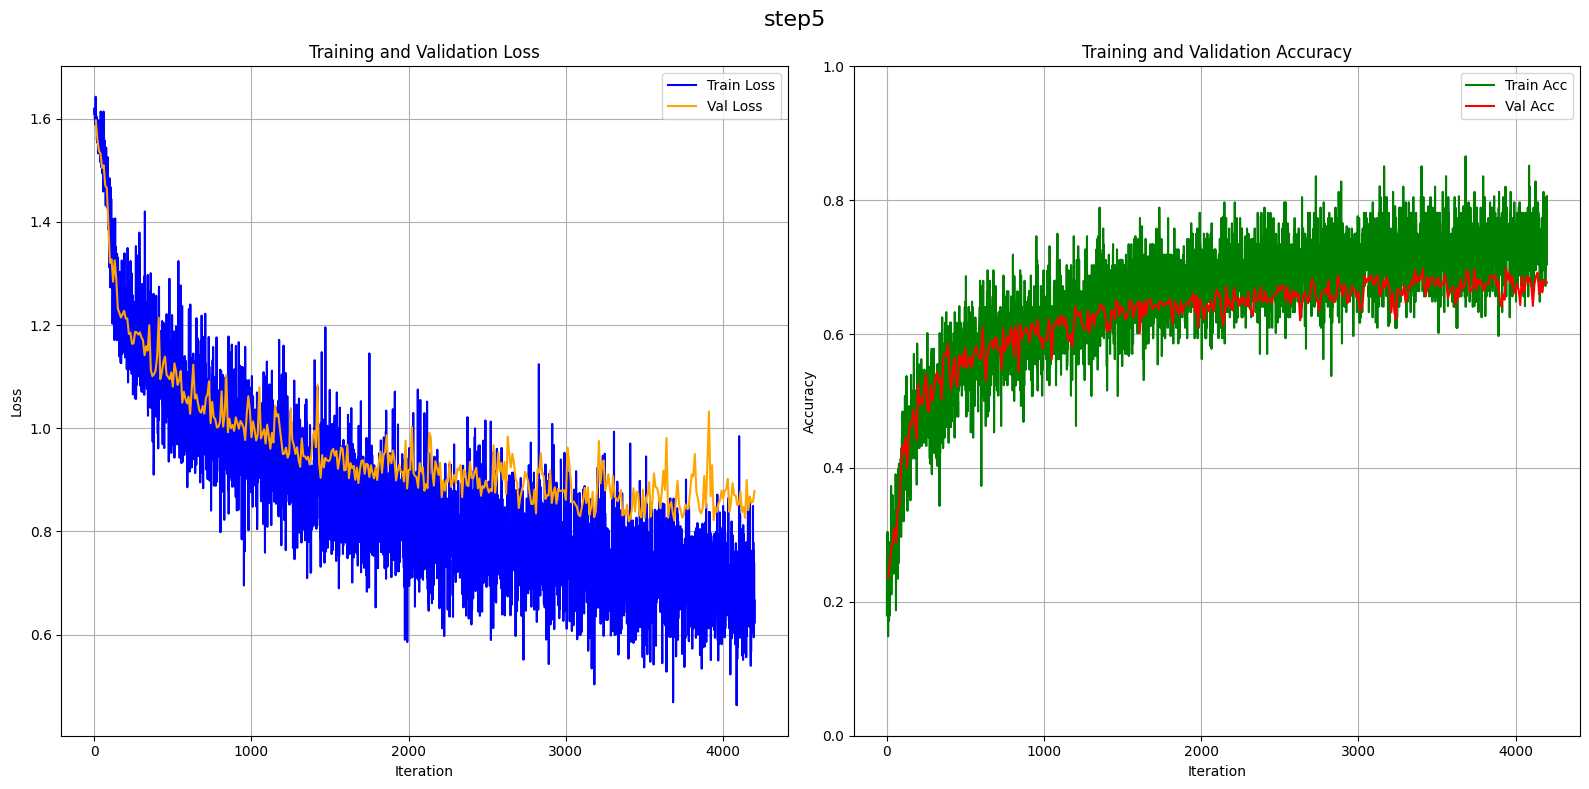

In [36]:
# We plot the curves using the iteration as the x-axis:
plt.figure(figsize=(16, 8))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df_train['Iteration'], df_train['Training Loss'], label='Train Loss', color='blue')
plt.plot(df_val['Iteration'], df_val['Validation Loss'], label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df_train['Iteration'], df_train['Training Accuracy'], label='Train Acc', color='green')
plt.plot(df_val['Iteration'], df_val['Validation Accuracy'], label='Val Acc', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.legend()

plt.suptitle(experimentName, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(outputFolder, 'training_curves.png'))
plt.show()

## 4.2) Compute metrics on the test dataset

**Q16.** Eval the model on the test dataset

Your code should store the predicted class number in the list `allYtest` and the actual true values in the list `allYtrue`

In [37]:
model.eval()
allYtest = []
allYtrue = []

with torch.no_grad():
    for images, labels in test_loader:
        # Send to gpu
        images = images.to(device)
        # Forward pass
        outputs = model(images)
        # Get back the predicted classes
        _, predicted = torch.max(outputs, 1)

        # Update lists
        allYtest.extend(predicted.cpu().numpy())
        allYtrue.extend(labels)

Display & save confusion matrix over the test dataset

Use the `classification_report` to display some metrics and confusion_matrix along with sb.heatmap to display the confusion matrix.
(sklearn confusion_matrix & classification report are already imported, cf beginning of the program)

Use Matplotlib to save the file in `os.path.join(outputFolder,'confusion_matrix_test.png')`

              precision    recall  f1-score   support

           0       0.75      0.76      0.75        50
           1       0.61      0.80      0.69        64
           2       0.61      0.61      0.61        49
           3       0.74      0.76      0.75        49
           4       0.55      0.35      0.43        60

    accuracy                           0.65       272
   macro avg       0.65      0.65      0.65       272
weighted avg       0.65      0.65      0.64       272



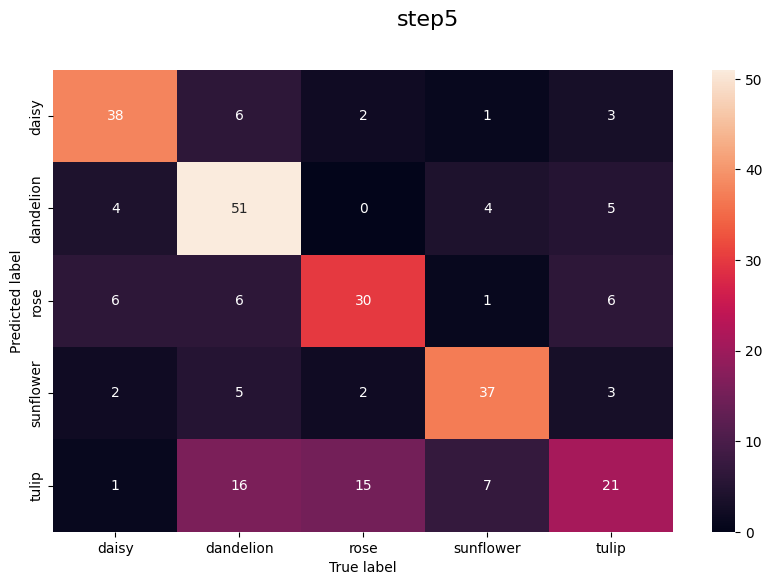

In [38]:
print(classification_report(allYtrue, allYtest))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(allYtrue, allYtest), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.suptitle(experimentName, fontsize=16)
plt.savefig(os.path.join(outputFolder, 'confusion_matrix_test.png'))

The following code save some data in "model_result.txt" a file with the result and the model structure for later analysis

In [39]:
modelStr = str(summary(model, input_size=[batchSize, 3, H, W]))
classificationReport = classification_report(allYtrue, allYtest)

with open(os.path.join(outputFolder, "model_result.txt"), "w", encoding="utf-8") as file:
    # write hyperparameters
    file.write(f"Parameter for run : {experimentName} \n")
    file.write(f"Training duration : {trainingDuration:.2e} s \n")
    file.write(f"Batch size   : {batchSize} \n")
    file.write(f"Image size   : ({H},{W})\n")
    file.write(f"learningRate : {learningRate:e} \n")
    file.write(f"numEpoch     : {numEpoch} \n")
    file.write(f"weight_decay : {weight_decay} \n")
    file.write("\n\n\n")
    file.write(classificationReport)
    file.write("\n\n\n")
    file.write(modelStr)

# 5) Classify some images

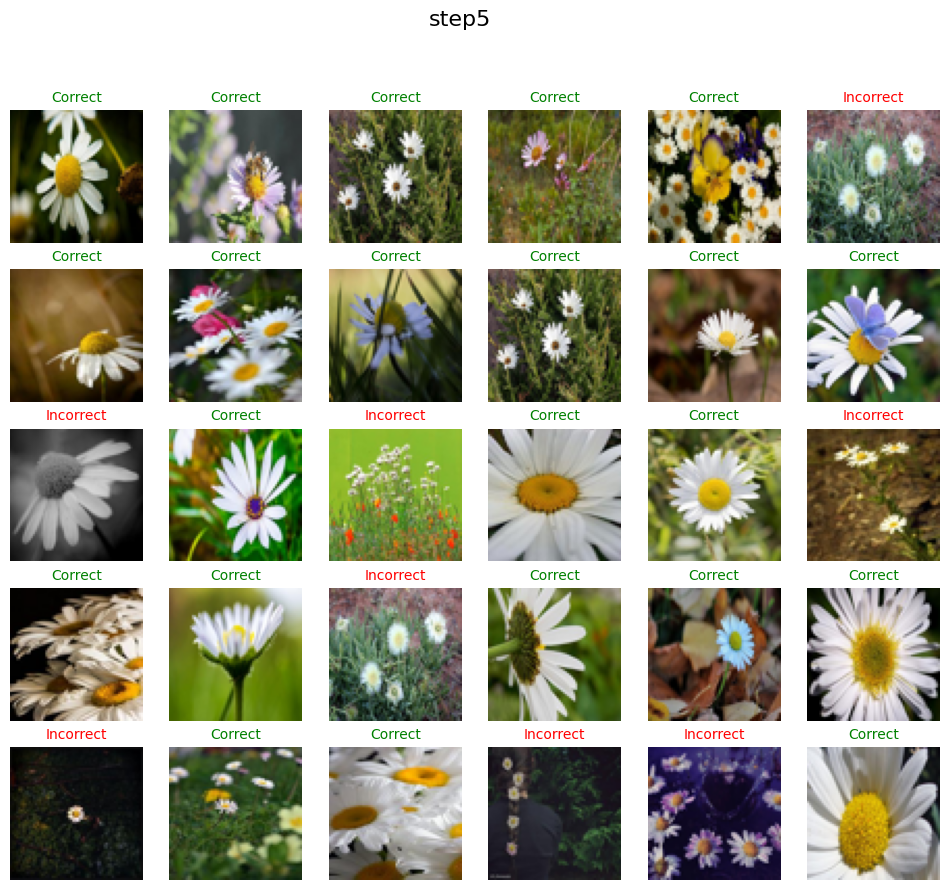

In [40]:
imgs, yTrue = next(iter(test_loader))
imgs = imgs.to(device)
logits = model(imgs)
yPred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
correct = yPred.to('cpu') == yTrue
imgs = imgs.to('cpu')

nImgs = 30
cols = int(math.ceil(math.sqrt(nImgs)))     # Number of columns (square root rounded up)
rows = int(math.ceil(nImgs / cols))         # Number of rows (ensure enough rows to fit images)

# Create the figure with the calculated number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Adjust figsize to the grid
axes = axes.ravel()

for i in range(nImgs):
    ax = axes[i]
    ax.imshow(imgs[i, :].permute(1, 2, 0))
    title = "Correct" if correct[i].item() else "Incorrect"  # Title based on the result
    ax.set_title(title, fontsize=10, color="green" if correct[i].item() else "red")  # Color-code titles
    ax.axis('off')

plt.suptitle(experimentName, fontsize=16)
plt.savefig(os.path.join(outputFolder, "sample_result.png"))

# Save data

In [41]:
def zip_compression_tree(folderIn, zip_name, ):
    with zipfile.ZipFile(zip_name, 'w') as z:
        for root, dirs, files in os.walk(folderIn):
            folderOut = root.split(os.path.commonpath([folderIn, root]))[1]
            for file in files:
                z.write(os.path.join(root, file), arcname=os.path.join(folderIn, folderOut, file))

To be run when all steps are done

In [42]:
# resultZipFilename = "result.zip"
# zip_compression_tree(outputFolder, resultZipFilename)

In [43]:
#from google.colab import files
#files.download(resultZipFilename)